<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/PPOGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

参考
https://github.com/vpj/rl_samples
http://blog.varunajayasiri.com/ml/ppo_pytorch.html

# GPU対応

In [ ]:
import random
import time
random.seed(time.time())

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))
print(device)

device(type='cuda', index=0)
cuda:0


# 外部ライブラリの追加




In [ ]:
#!pip install pfrl > /dev/null
#!pip install wandb > /dev/null

# ライブラリのインポート

In [ ]:
import multiprocessing
import multiprocessing.connection
from typing import Dict, List

import gym
from gym import ObservationWrapper
from gym.spaces import Box

import cv2
import numpy as np
import torch

from torch import nn
from torch import optim
from torch.distributions import Categorical
from torch.nn import functional as F

from pfrl.wrappers.atari_wrappers import FrameStack,NoopResetEnv,MaxAndSkipEnv
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt


# ラッパー定義

In [ ]:
class myCrop(ObservationWrapper):
    def __init__(self, env, tmgn=0, bmgn=0,lmgn=0,rmgn=0,igcolors=[],bgcolor=[0,0,0]):
        super(myCrop, self).__init__(env)
        self.tmgn, self.bmgn = tmgn, bmgn
        self.lmgn, self.rmgn = lmgn, rmgn
        self.igcolors, self.bgcolors = igcolors, bgcolor
        self.observation_space = Box(low=0, high=255, shape=(84,84), dtype=np.uint8)
    def observation(self, obs):
        img_mask = np.zeros(obs.shape[:2],np.uint8)
        for color in self.igcolors:
            bgrLower = np.array(color)    
            bgrUpper = np.array(color)
            tmask = cv2.inRange(obs, bgrLower, bgrUpper) 
            img_mask = cv2.bitwise_or(img_mask,tmask)
        obs = cv2.bitwise_and(obs,obs,mask=255-img_mask) # 元画像とマスクを合成
        RIGHT=obs.shape[1]-self.rmgn
        BOTTOM=obs.shape[0]-self.bmgn
        obs = obs[self.tmgn:BOTTOM,self.lmgn:RIGHT]
        obs = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        observation = cv2.resize(obs, (84, 84), interpolation=cv2.INTER_AREA)
        return observation

class myFrameStack(FrameStack):
    def __init__(self, env, k=4, deadloss=0):
        super(myFrameStack, self).__init__(env, k=k, channel_order="chw")
        self.deadloss = deadloss
        self.lives = 0
        self.lsumrewards = 0
        self.localsteps = 0
    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        self.lives = self.env.unwrapped.ale.lives()
        self.lsumrewards = 0
        self.localsteps = 0
        return  self.obs_to_torch(np.array(list(self.frames)))
    def step(self, action):
        ob, reward, done1, info = self.env.step(action)
        self.frames.append(ob)
        rewardalpha = reward
        episode_info = None
        # 残機数確認
        lives = self.env.unwrapped.ale.lives()
        self.localsteps += 1  
        self.lsumrewards += reward
        if done1 or lives < self.lives: # １機死んだら終了とする
            done = True
            if lives < self.lives:
                rewardalpha = reward - self.deadloss # 機体を失うことのペナルティ
        else:
            done = False
        if self.localsteps % 50 == 0 or done:
              episode_info = {"reward": self.lsumrewards, "length": self.localsteps}
        if done:
            self.reset()
        return  self.obs_to_torch(np.array(list(self.frames))), rewardalpha, done, episode_info
    @staticmethod
    def obs_to_torch(obs: torch.Tensor) -> torch.Tensor:
        return torch.tensor([obs], dtype=torch.float32, device=device) / 255.

def mkenv(envname,k=8,skip=2,tmgn=0,bmgn=0,lmgn=0,rmgn=0,igcolors=[],deadloss=0):
  env=gym.make(envname)
  env = NoopResetEnv(env, noop_max=1)
  env = MaxAndSkipEnv(env, skip=skip)
  env=myCrop(env, tmgn=tmgn, bmgn=bmgn, lmgn=lmgn, rmgn=rmgn, igcolors=igcolors)
  env=myFrameStack(env,k=k,deadloss=deadloss)
  return env

# Game Environmentの定義

In [ ]:
import random
from datetime import datetime
random.seed(datetime.now())
DEFAULTSEED = random.randint(1, 10000)
def Game(seed=DEFAULTSEED,k=8,skip=1,deadloss=0):
    ENV_NAME = 'SpaceInvadersNoFrameskip-v4'
    Tmgn=20
    Bmgn=12
    Lmgn=8
    Rmgn=8
    #NOCOLOR=[[162,134,56]]  # 背景と同一視するカラー
    NOCOLOR=[]  # 背景と同一視するカラー

    env = mkenv(ENV_NAME,k,skip,Tmgn,Bmgn,Lmgn,Rmgn,NOCOLOR,deadloss=deadloss)
    env.seed(seed)
    return env

### 補足
**k** : 過去何フレーム分の画面をデータとするか  
**skip** : 何フレームおきにサンプリングするか  
**Tmgn,Bmgn,Lmgn,Rmgn** カットする余白量  
**NOCOLOR** 黒に置き換える色をRGB指定。複数指定
可能  
上の設定はインベ ー め打ち



## 動作確認

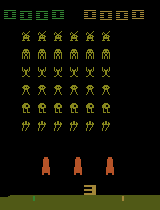

(210, 160, 3)

(8, 84, 84)

0.0

0.36862746

numpy.float32

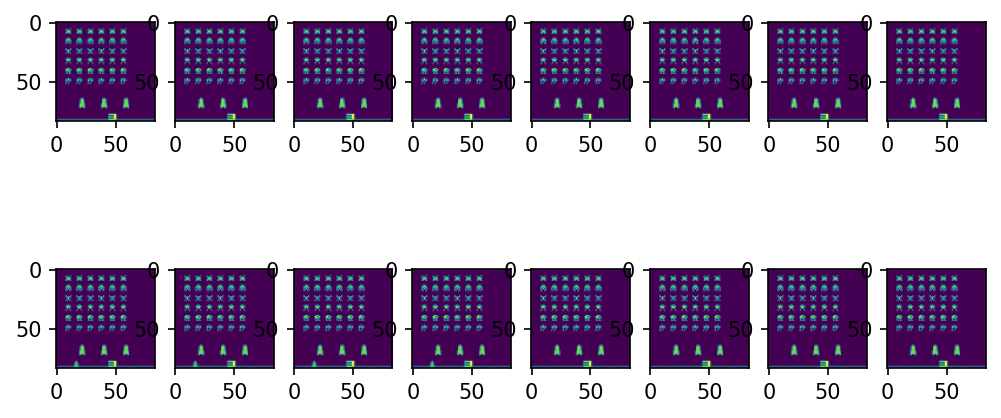

In [ ]:
import random
from datetime import datetime
DEFAULTSEED = random.seed(datetime.now())

# 原画像が表示できるかテスト
game = Game(DEFAULTSEED)
orgimg = game.render(mode='rgb_array')
display(Image.fromarray(orgimg))
display(orgimg.shape)

# リセット画像の確認
plt.figure(figsize=(8,4),dpi=150)
imgs = game.reset()
imgs = imgs[0].cpu().numpy()
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+1)
    plt.imshow(img)
# ステップ画像の確認
for _ in range(60):
  imgs,r,d,i= game.step(game.action_space.sample()) 
imgs = imgs[0].cpu().numpy()
for i,img in enumerate(imgs):
    plt.subplot(2,8,i+9)
    plt.imshow(img)
    
# Check types
display(imgs.shape,imgs[0,0,0],imgs[0,40,40],type(imgs[0,0,0]))

# PPO用ニューラルネットのモデル定義




In [ ]:
from torch import nn
class Model(nn.Module):

    def __init__(self,nframes=8):
        super().__init__()

        # 4x84x84 → 32x20x20 
        self.conv1 = nn.Conv2d(in_channels=nframes, out_channels=32, kernel_size=8, stride=4)
        # 32x20x20 →64x9x9
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        # 64x9x9 → 64x7x7 
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        # 64x7x7 → 512 
        self.lin = nn.Linear(in_features=7 * 7 * 64, out_features=512)
        # 512 → 4 actions 0-1 （行動決定）
        self.pi_logits = nn.Linear(in_features=512, out_features=4)
        # 行動価値
        self.value = nn.Linear(in_features=512, out_features=1)

    def forward(self, obs: torch.Tensor):
        h = F.relu(self.conv1(obs))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = h.reshape((-1, 7 * 7 * 64))

        h = F.relu(self.lin(h))

        pi = Categorical(logits=self.pi_logits(h))
        value = self.value(h).reshape(-1)

        return pi, value

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))
print(device)

model = Model()
model.to(device)
obs = game.reset()
pi,v = model.forward(obs)

a0 = pi.sample() # 方策関数によりアクションを決定
a = a0.cpu().numpy()[0] # アクション番号の数値化
b = pi.log_prob(a0) # 

display(obs.shape) # 画面データのシェイプを表示
display(a) # 選ばれたアクション番号を表示
display(b) # 
display(v.detach()) # 状態価値を表示
display(model) # モデルを表示

device(type='cuda', index=0)
cuda:0


torch.Size([1, 8, 84, 84])

2

tensor([-1.3699], device='cuda:0', grad_fn=<SqueezeBackward1>)

tensor([-0.0064], device='cuda:0')

Model(
  (conv1): Conv2d(8, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (lin): Linear(in_features=3136, out_features=512, bias=True)
  (pi_logits): Linear(in_features=512, out_features=4, bias=True)
  (value): Linear(in_features=512, out_features=1, bias=True)
)

# Multiprocessing Playloop

# 学習のメインプログラム
### ログフォルダの設定

In [ ]:
import os
PROJECTNAME = 'ppo8players'
SAVEFOLDER = '/root/M/{}'.format(PROJECTNAME)
os.makedirs(SAVEFOLDER,exist_ok=True)

In [ ]:
from tqdm.notebook import tqdm
ENDGREEDYCYCLES = 1000
GreedyEPS_START = 0.3 
GreedyEPS_END = 0.05
# Hyper Parameters
GAMMA = 0.99
LAMDA = 0.95
NCYCLES = 1200 # 学習サイクル数　（データ収集→学習　が1サイクル）
EPOCKS =  4 # サンプル１セットを何度学習プロセスに通すか
NPLAYERS = 16 # 並列実行する数game
NBATCHES = 128 # １度に処理するデータ数
NDIVIDE = 4 # バッチの分割数
SEEDZero = random.randint(1,10000)
LearningRate = 0.0002
NFRAMES = 12
W_VFLOSS = 0.5 # loss におけるvfloss の重み
W_BONUS = 0.01 # loss における entropy bonus の重み
CLIPRANGE = 0.2 # ## Run it

# エージェントとして独立にゲームを実行するプレイヤのクラス定義
class CoPlayer:
    def __init__(self, seed, k=4,deadloss=0):
        self.game = Game(seed=seed, k=k,deadloss=deadloss)

class Main:

    def __init__(self, seed = 0,deadloss=0):

        self.progress = progress = 0
        
        # 1サイクルに必要なサンプル数
        self.batch_size = NPLAYERS * NBATCHES
        # ミニバッチのサイズ
        self.mini_batch_size = self.batch_size // NDIVIDE

        # 初期化
        # CoPlayerの生成
        self.coplayers = [CoPlayer(SEEDZero + i, NFRAMES,deadloss) for i in range(NPLAYERS)]

        # 観測テンソルの初期化
        self.obs = torch.zeros((NPLAYERS, NFRAMES, 84, 84), dtype=torch.float32)
        for i,player in enumerate(self.coplayers):
            self.obs[i] = player.game.reset()
          
        # model for sampling
        self.model = Model(NFRAMES) 

        # optimizer
        self.optimizer = optim.Adam(self.model.parameters(), lr=LearningRate,betas = (0.9, 0.999))

    def sample(self) -> (Dict[str, np.ndarray], List):
    #def sample(self) -> (Dict[str, torch.Tensor], List):
        # 学習データの記憶域確保
        '''
        rewards = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        actions = np.zeros((NPLAYERS, NBATCHES), dtype=np.int32)
        done = np.zeros((NPLAYERS, NBATCHES), dtype=np.bool)
        obs = torch.zeros((NPLAYERS, NBATCHES, NFRAMES, 84, 84), dtype=torch.float32)
        log_pis = np.zeros((NPLAYERS, NBATCHES, dtype= np.float32)
        values = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)'''
        rewards = torch.zeros((NPLAYERS, NBATCHES), dtype=torch.float32)
        actions = torch.zeros((NPLAYERS, NBATCHES), dtype=torch.int32)
        done = torch.zeros((NPLAYERS, NBATCHES), dtype=torch.bool)
        obs = torch.zeros((NPLAYERS,NBATCHES, NFRAMES, 84, 84), dtype=torch.float32)
        log_pis = torch.zeros((NPLAYERS, NBATCHES), dtype= torch.float32)
        values = torch.zeros((NPLAYERS, NBATCHES), dtype=torch.float32)
        
        # 画像データの初期化
        for t in range(NBATCHES): # 各初期シーンに対し、
            with torch.no_grad(): # 傾きを固定して実行
                obs[:, t] = self.obs.clone().detach()  # 黒画面をプレイヤ数複製
                pi, v = self.model(self.obs)   # モデルで pi, v を初期化 
                values[:, t] = v.clone().detach() # 初期シーンの評価値を各プレイヤに伝達
                         
                # epsiron greedy action selection
                if self.progress >= ENDGREEDYCYCLES:
                    g_eps = GreedyEPS_END
                else:
                    g_eps = GreedyEPS_START + self.progress * (GreedyEPS_END - GreedyEPS_START) 
                if torch.rand(1) <= g_eps:  # ランダム行動
                    a = torch.randint(0,4,(1,))
                else:
                    a = pi.sample() # アクションをランダムに発生
                
                actions[:, t] = a.clone().detach() #.各プレイヤにアクション伝達
                va = pi.log_prob(a) 
                log_pis[:, t] = va.clone().detach()# アクションの評価値を伝達

            lorew,lolen,lon = 0,0,0
            for w, player in enumerate(self.coplayers):
                self.obs[w], rewards[w, t], done[w, t], info = player.game.step(actions[w, t])
                if info:
                    lorew += info['reward']
                    lolen += info['length']
                    lon += 1
            if lon > 0:
                wandb.log({'reward':lorew/lon,'lengt':lolen/lon})
             
        # calculate advantages
        advantages = self._calc_advantages(done, rewards, values)
        samples = {
            'obs': obs,
            'actions': actions,
            'values': values,
            'log_pis': log_pis,
            'advantages': advantages
        }

        samples_flat = {}
        for k, v in samples.items():
            v = v.reshape(v.shape[0] * v.shape[1], *v.shape[2:])
            samples_flat[k] = torch.tensor(v, device=device)
            '''
            if k == 'obs':
                samples_flat[k] = v
            else:
                samples_flat[k] = torch.tensor(v, device=device)'''

        return samples_flat

    #def _calc_advantages(self, done: np.ndarray, rewards: np.ndarray, values: np.ndarray) -> np.ndarray:
    def _calc_advantages(self, done: torch.Tensor, rewards: torch.Tensor, values: torch.Tensor) -> torch.Tensor:
        #advantages = np.zeros((NPLAYERS, NBATCHES), dtype=np.float32)
        advantages = torch.zeros((NPLAYERS, NBATCHES), dtype=torch.float32)
        last_advantage = 0
        _, last_value = self.model(self.obs)
        last_value = last_value
        for t in reversed(range(NBATCHES)):
            #mask = 1 - done[:, t]
            # mask = ~done[:, t]
            mask = torch.Tensor([1 if ~d else 0 for d in done[:,t]])
            last_value = last_value * mask
            last_advantage = last_advantage * mask
            delta = rewards[:, t] + GAMMA * last_value - values[:, t]
            last_advantage = delta + GAMMA * LAMDA * last_advantage
            advantages[:, t] = last_advantage
            last_value = values[:, t]

        return advantages
    
    # 1サイクルの学習
    def train(self, samples: Dict[str, torch.Tensor], learning_rate: float, clip_range: float):

        for _ in range(EPOCKS):
            # 並べ替え用の数列
            indexes = torch.randperm(self.batch_size)

            # ミニバッチ単位で処理
            for start in range(0, self.batch_size, self.mini_batch_size):
                # get mini batch
                end = start + self.mini_batch_size
                mini_batch_indexes = indexes[start: end]
                mini_batch = {}
                for k, v in samples.items():
                    mini_batch[k] = v[mini_batch_indexes]

                # train
                loss = self._calc_loss(clip_range=clip_range,samples=mini_batch)

                # compute gradients
                for pg in self.optimizer.param_groups:
                    pg['lr'] = learning_rate
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=0.5)
                self.optimizer.step()

    @staticmethod
    def _normalize(adv: torch.Tensor):
        return (adv - adv.mean()) / (adv.std() + 1e-8)

    def _calc_loss(self, samples: Dict[str, torch.Tensor], clip_range: torch.Tensor) -> torch.Tensor:
        sampled_return = samples['values'] + samples['advantages']
        sampled_normalized_advantage = self._normalize(samples['advantages'])
        pi, value = self.model(samples['obs'])

        # #### Policy

        log_pi = pi.log_prob(samples['actions'])

        ratio = torch.exp(log_pi - samples['log_pis'])

        clipped_ratio = ratio.clamp(min=1.0 - clip_range,
                                    max=1.0 + clip_range)
        policy_reward = torch.min(ratio * sampled_normalized_advantage,
                                  clipped_ratio * sampled_normalized_advantage)
        policy_reward = policy_reward.mean()

        # #### Entropy Bonus
        entropy_bonus = pi.entropy()
        entropy_bonus = entropy_bonus.mean()

        # #### Value
        clipped_value = samples['values'] + (value - samples['values']).clamp(min=-clip_range,
                                                                              max=clip_range)
        vf_loss = torch.max((value - sampled_return) ** 2, (clipped_value - sampled_return) ** 2)
        vf_loss = 0.5 * vf_loss.mean()
        loss = -(policy_reward - W_VFLOSS* vf_loss + W_BONUS  * entropy_bonus)

        # for monitoring
        approx_kl_divergence = .5 * ((samples['log_pis'] - log_pi) ** 2).mean()
        clip_fraction = (abs((ratio - 1.0)) > clip_range).to(torch.float).mean()

        wandb.log({'policy_reward': policy_reward.cpu(),
                     'vf_loss': vf_loss.cpu(),
                     'entropy_bonus': entropy_bonus.cpu(),
                     'kl_div': approx_kl_divergence.cpu(),
                     'clip_fraction': clip_fraction.cpu()})   
        return loss

    def run_training_loop(self):

        ### Run training loop
        pbar = tqdm(range(NCYCLES))
        for cycle in pbar:
        #for cycle in range(NCYCLES):
            pbar.set_description('tran loop')
            self.progress = progress = cycle / NCYCLES

            # decreasing `learning_rate` and `clip_range` 
            learning_rate = LearningRate * (1 - progress)
            clip_range = CLIPRANGE * (1 - progress)
            samples = self.sample()
            # train the model
            self.train(samples, learning_rate, clip_range)

            # write summary info to the writer, and log to the screen
            if (cycle + 1) % 100 == 0:
                torch.save(self.model.state_dict(),SAVEFOLDER+"/model" )
            if (cycle + 1) % 250 == 0:
                torch.save(self.model.state_dict(),SAVEFOLDER+'/model{}'.format(cycle+1))

    def destroy(self):

        for player in self.coplayers:
            player.child.send(("close", None))

# W and B

In [ ]:
# Inside my model training code
import wandb
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'PPOJetson'
wandb.init(project=PROJECTNAME)

reward,75.0
lengt,1000.0
_step,1455
_runtime,1064
_timestamp,1608560591
policy_reward,0.00563
vf_loss,9.55887
entropy_bonus,1.36052
kl_div,0.0031
clip_fraction,0.21094


reward,▁▂▁▁▂▁▂▁▂▁▂▂▁▃▁▂▁▂▂█▃▃▁▁▃▆▁▁▁▁▂▂▂▁▂▂▁▃▁▃
lengt,▂▃▁▂▂▂▃▂▃▃▃▃▃▃▃▃▂▃▃▅▄▄▁▃▅█▂▁▁▂▄▄▂▂▂▃▁▂▂▄
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_runtime,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
policy_reward,▆▆▅▆▅▅▆▇▇▅▁▆▅▄▆▇▄▅▆▇▅▅▆▄▅▅▆▆▆▅▆▇█▆▃▄▅▆▄▇
vf_loss,▁▁▁▁▁▂▂▂▂▁▂▁▁▁▂▁▂▂▁▂▁▁▅▁▂▂▁▂▂█▁▂▂▁▆▂▂▂▂▁
entropy_bonus,████▇█▇▆▇▄▄▁▃▃▃▃▄▄▃▃▄▄▃▄▁▂▅▄▅▄▅▅▅▅▇▆▇▆▆▆
kl_div,▁▂▁▃▃▁▂█▃▇▄▅▃▄▃▄▂▂▃▃▃▄▂▃▃▄▃▄▂▃▂▇▃▃▅▄▂▃▄▃
clip_fraction,▁▁▁▃▅▁▂█▃▇▅▅▃▅▃▅▂▂▃▂▃▅▂▃▃▄▃▄▂▃▃▆▃▄▅▄▂▄▄▄


In [ ]:

torch.set_default_tensor_type('torch.cuda.FloatTensor')
if __name__ == "__main__":
    #experiment.create(name="PPOsimgle.ipynb")
    m = Main(SEEDZero,deadloss=50)
    #experiment.start()
    m.run_training_loop()
    m.destroy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(),'ppomodel')
# model.load_state_dict(torch.load('ppomodel'))
# torch.save(model.state_dict(),'ppomodel{}'.format(100))